In [135]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pyaudio

## Record Audio

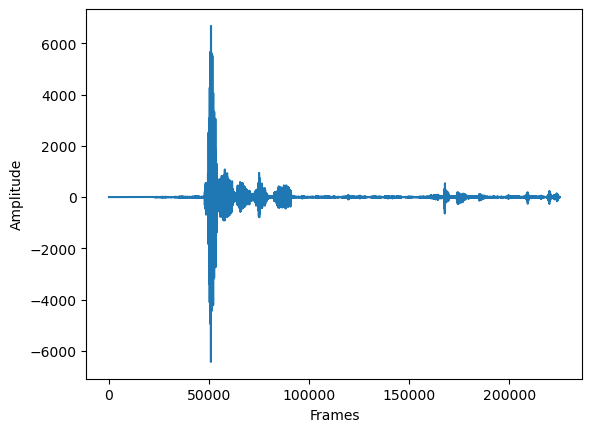

In [136]:
FORMAT = pyaudio.paInt16
SAMPLEFREQ = 44100
FRAMESIZE = 1024
NOFFRAMES = 220
p = pyaudio.PyAudio()

stream = p.open(format=FORMAT, channels=1, rate=SAMPLEFREQ, input=True, frames_per_buffer=FRAMESIZE)
data = stream.read(NOFFRAMES*FRAMESIZE)
decoded = np.frombuffer(data, "int16")
stream.stop_stream()
stream.close()


plt.plot(decoded)
plt.ylabel("Amplitude")
plt.xlabel("Frames")
plt.show()



# Input normalisieren

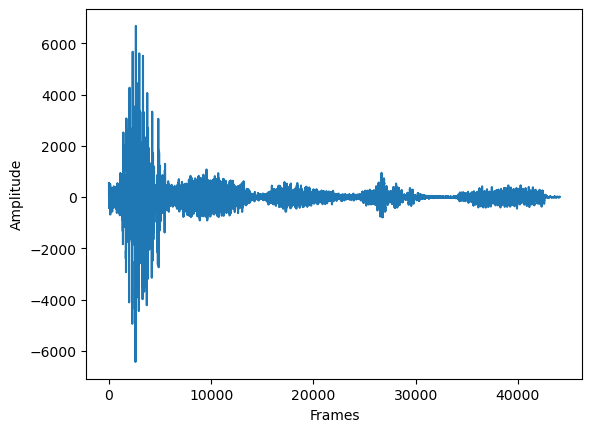

In [137]:
for i, v in enumerate(decoded):
    if v > 500:
        decoded = decoded[i:]
        break
if len(decoded) > SAMPLEFREQ:
    decoded = decoded[:SAMPLEFREQ]
while len(decoded) < SAMPLEFREQ:
    np.append(decoded, 0)

plt.plot(decoded)
plt.ylabel("Amplitude")
plt.xlabel("Frames")
plt.show()

np.save("Jonas1", decoded)

# Import npy file

In [138]:
data = np.load("Messdaten/hoch/hoch0.npy")

# Amplitudenspektrum

Text(0.5, 1.0, 'Amplitude Spectrum')

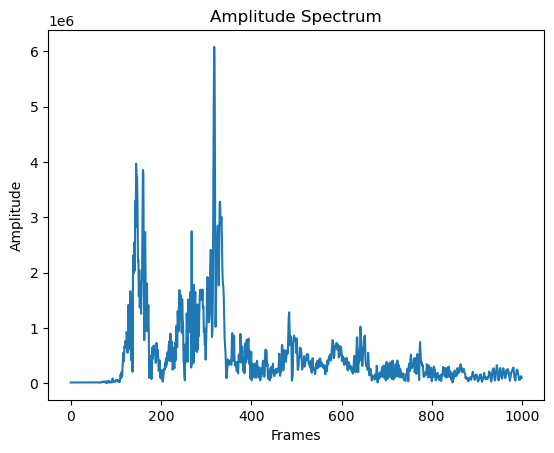

In [139]:
fourier_transform = np.fft.fft(data)
amplituden = np.abs(fourier_transform)

plt.plot(amplituden[:1000])
plt.xlabel('Frames')
plt.ylabel('Amplitude')
plt.title('Amplitude Spectrum')

# Windowing

In [140]:
def windowing(win_data):
    windowSize = 512
    window = scipy.signal.windows.gaussian(windowSize, std=windowSize/4)
    windows_fft = []

    for i in range(0, SAMPLEFREQ, int(windowSize/2)):
        localData = data[i:i+windowSize]
        if len(localData) != 512:
            continue
        local_fft = np.fft.fft(localData*window)
        windows_fft.append(local_fft)
    mean_fft = np.array(windows_fft).mean(axis=0)
    amplituden = np.abs(mean_fft)
    return amplituden

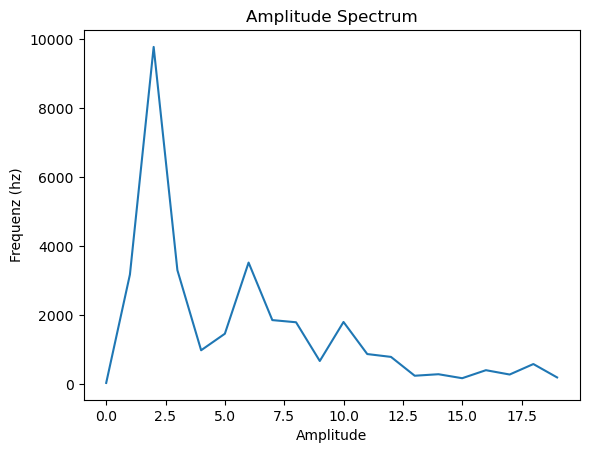

In [141]:
plt.plot(windowing(data)[:20])
plt.title("Amplitude Spectrum")
plt.xlabel("Amplitude")
plt.ylabel("Frequenz (hz)")
plt.show()

# Daten einlesen

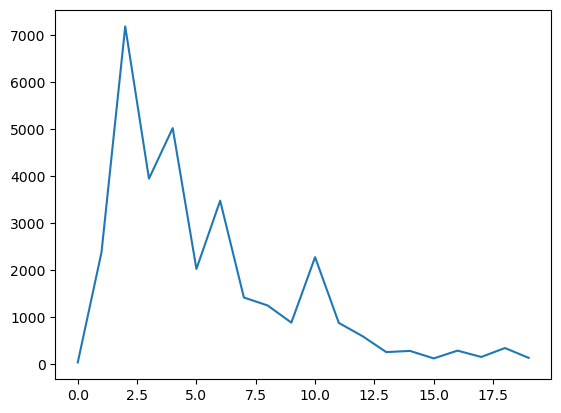

In [142]:

befehle = ["hoch", "runter", "links", "rechts"]
befehle = ["hoch"]

data_dict = {}
for befehl in befehle:
    data_dict[befehl] = []
    for i in range(2):
        data = np.load(f"Messdaten/{befehl}/{befehl}{i}.npy")
        data_dict[befehl].append(windowing(data))
    data_dict[befehl] = np.array(data_dict[befehl]).mean(axis=0)

plt.plot(data_dict["hoch"][:20])
plt.show()
